In [1]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import datetime
import xml.etree.ElementTree as ET
import shutil

import freewayControl as fc
import connectedEnv as cv

import ytlib

import traci
from sumolib import checkBinary

In [2]:
def startSumo(simFile, simSeed, simMode="sumo-gui", 
              traj=False, trajFile=None, trajStartTime=None,
              tripInfo=False, tripInfoFile=None):
    
    simSettings = [checkBinary(simMode), 
                   "-c", simFile, 
                   "--step-length", "1", 
                   "--seed", str(simSeed), 
                   "--no-warnings", "true", 
                   "--collision.action", "none"]
    
    if traj:
        simSettings.append("--fcd-output")
        simSettings.append(trajFile)
        simSettings.append("--device.fcd.begin")
        simSettings.append(str(trajStartTime))
        
        
    if tripInfo:
        simSettings.append("--tripinfo-output")
        simSettings.append(tripInfoFile)
        
        
    if simMode == "sumo-gui":
        simSettings.extend(["--start", "true"])
        simSettings.extend(["--quit-on-end", "true"])
    
    
    traci.start(simSettings)
    return traci.getConnection()


In [3]:
# Check whether Output directory exists.
if not os.path.exists("./SUMO (many incidents)/Output"):
    os.mkdir("./SUMO (many incidents)/Output")


randomSeed = 42
sumo = startSumo("./SUMO (many incidents)/I210.sumocfg", randomSeed, "sumo-gui",
                 traj=False, trajFile="./SUMO (many incidents)/Output/traj.xml", trajStartTime=4*3600,
                 tripInfo=True, tripInfoFile="./SUMO (many incidents)/Output/tripInfo.xml")


env = fc.SimulationEnvironment(sumo)

bsmKeeper = cv.BSMKeeper(env, obsPeriod=30)

inflowEstimator1 = cv.FlowEstimator(30, [[17707, 2267], [17707, 2279]], ["S62_M"], 0.25*0.85, 4)
outflowEstimator1 = cv.FlowEstimator(30, [[17773, 2255], [17773, 2270]], ["S62_M"], 0.25*0.85, 4)
travelTimeEstimator1 = cv.TravelTimeEstimator([[16613, 2254], [16613, 2277]], 
                                              [[17707, 2267], [17707, 2279]], 
                                              ["S59_M", "S60_M", "S61_M", "S62_M", "S63_M"], 
                                              1.199)
densityEstimator1 = cv.TrafficDensityEstimator([[17707, 2267], [17707, 2279]], 
                                               [[17773, 2255], [17773, 2270]], ["S62_M"], 
                                               0.066, 0.25*0.85, 30, 4)


inflowEstimator2 = cv.FlowEstimator(30, [[9625, 3744], [9625, 3754]], ["S38_M"], 0.25*0.85, 4)
outflowEstimator2 = cv.FlowEstimator(30, [[9695, 3744], [9695, 3754]], ["S38_M"], 0.25*0.85, 4)
travelTimeEstimator2 = cv.TravelTimeEstimator([[8425, 3729], [8425, 3758]], 
                                              [[9625, 3744], [9625, 3754]], 
                                              ["S37_M", "S38_M", "S39_M"], 
                                              1.2)
densityEstimator2 = cv.TrafficDensityEstimator([[9625, 3744], [9625, 3754]], 
                                               [[9695, 3744], [9695, 3754]], ["S38_M"], 
                                               0.07, 0.25*0.85, 30, 4)



meters = []
rampEntryInductionLoops = []
rampExitInductionLoops = []
meteringInductionLoops = []
rampLaneAreaDetectors = []

controllers = []

with open("meteringConfig.json") as f:
    configs = json.load(f)

    for meterID, config in configs.items():
        meters.append(fc.RampMeter(env, meterID, [config["greenPhaseID"], config["redPhaseID"]], 
                                   numRampLane=config["numRampLane"], 
                                   numVehPerGreenPerLane=config["numVehPerGreenPerLane"],
                                   greenPhaseLen=config["greenPhaseLen"], 
                                   redPhaseLen=config["minRedPhaseLen"], 
                                   minRedPhaseLen=config["minRedPhaseLen"], 
                                   maxRedPhaseLen=config["maxRedPhaseLen"]))

        rampEntryInductionLoops.append(fc.InductionLoop(env, inductionLoopIDs=config["rampEntryInductionLoops"],
                                                        flowObsPeriod=30, occObsPeriod=30))
        
        rampExitInductionLoops.append(fc.InductionLoop(env, inductionLoopIDs=config["rampExitInductionLoops"],
                                                       flowObsPeriod=30, occObsPeriod=30))
        
        # Do not include sensor on acceleration lanes.
        meteringInductionLoops.append(fc.InductionLoop(env, inductionLoopIDs=config["mainlineInductionLoops"][1:],
                                                       flowObsPeriod=30, occObsPeriod=30))
        
        rampLaneAreaDetectors.append(fc.LaneAreaDetector(env, config["rampLaneAreaDetectors"]))
        
        controllers.append(fc.QueueInformedALINEA(env, meters[-1], 
                                                  meteringUpdateFreq=30, 
                                                  gain=30,
                                                  mainlineSetpoint=15,
                                                  allowedMaxRampQueueLen=0.8*config["maxVehNum"],
                                                  hasRampQueueOverride=True))
        


# Initialize ramp metering coordinator (HERO).
coordinator = fc.HeuristicRampMeteringCoordinator(controllers)

 Retrying in 1 seconds


In [4]:
totalTime = 3600 * 7
updateFreq = 30

incidentStart_1 = 4*3600+7*60 # incident start time: 17:07, location: 36.2 mile (between mainline 18 and 19)

incidentStart_2 = 4*3600+30*60 # incident start time: 17:30, location 31.1 mile (between mainline 9 and 10)


startTimestamp = datetime.datetime.now()


In [148]:
for _ in range(600):
    
    if env.step == incidentStart_1:
        sumo.vehicle.add(vehID="accident1", routeID="S25_M_S71_M", typeID="car1")
        sumo.vehicle.moveTo("accident1", "S62_M_2", 315)
        sumo.vehicle.setStop(vehID="accident1", edgeID="S62_M", 
                             pos=316, laneIndex=2, duration=47*60) # duration: 47 min

    if env.step == incidentStart_2:
        sumo.vehicle.add(vehID="accident2", routeID="S25_M_S71_M", typeID="car1")
        sumo.vehicle.moveTo("accident2", "S38_M_2", 269)
        sumo.vehicle.setStop(vehID="accident2", edgeID="S38_M", 
                             pos=270, laneIndex=2, duration=20*60) # duration: 20 min

    # Set metering rates from t to t+1.
    for controller in controllers:
        controller.meter.run()
    
    # Simulate from t to t+1.
    sumo.simulationStep()

    # Update at t+1.
    env.update()

    if (env.step > 4*3600) and ((env.step <= 4*3600+10*60+120)):
        bsmKeeper.collectBSM()
            
    for inductionLoop in rampEntryInductionLoops:
        inductionLoop.collectData()
    
    for inductionLoop in rampExitInductionLoops:
        inductionLoop.collectData()
        
    for inductionLoop in meteringInductionLoops:
        inductionLoop.collectData()
            
    
    if env.step % updateFreq == 0:
        
        for inductionLoop in rampEntryInductionLoops:
            inductionLoop.updateFlowMeasurement()
            inductionLoop.updateOccMeasurement()
            
        for inductionLoop in rampExitInductionLoops:
            inductionLoop.updateFlowMeasurement()
            inductionLoop.updateOccMeasurement()
        
        for inductionLoop in meteringInductionLoops:
            inductionLoop.updateFlowMeasurement()
            inductionLoop.updateOccMeasurement()
        
        for lanearea in rampLaneAreaDetectors:
            lanearea.updateVehicleNumberMeasurement()
        
        
        if (env.step > 4*3600+10*60) and ((env.step <= 4*3600+10*60+60)):
            bsmKeeper.generateSampledTrajectories()
            
            inflowEstimator1.updateEstimation(bsmKeeper.sampledTraj)
            outflowEstimator1.updateEstimation(bsmKeeper.sampledTraj)
            travelTimeEstimator1.updateEstimation(bsmKeeper.sampledTraj)
            densityEstimator1.updateEstimation(bsmKeeper.sampledTraj, env.step)
            
            
            inflowEstimator2.updateEstimation(bsmKeeper.sampledTraj)
            outflowEstimator2.updateEstimation(bsmKeeper.sampledTraj)
            travelTimeEstimator2.updateEstimation(bsmKeeper.sampledTraj)
            densityEstimator2.updateEstimation(bsmKeeper.sampledTraj, env.step)
            
        
        measurements = []
        occs = []
        queuelens = []
        rampFlows = []
        queueIndicators = []
        for i, controller in enumerate(controllers):
            if i == 3:
                if (env.step > 4*3600+10*60) and ((env.step <= 4*3600+10*60+60)):
                    measurements.append({"nearbyDownstreamMainlineOcc": meteringInductionLoops[i].edgeOcc,
                                         "rampQueueLen": rampLaneAreaDetectors[i].numVeh,
                                         "rampDemand": rampEntryInductionLoops[i].edgeFlow,
                                         "rampQueueIndicator": rampEntryInductionLoops[i].queueIndicator,
                                         "infow": inflowEstimator1.smoothedFlow,
                                         "outflow": outflowEstimator1.smoothedFlow,
                                         "travelTime": travelTimeEstimator1.travelTime,
                                         "density": densityEstimator1.smoothedDensity})
                else:
                    measurements.append({"nearbyDownstreamMainlineOcc": meteringInductionLoops[i].edgeOcc,
                                         "rampQueueLen": rampLaneAreaDetectors[i].numVeh,
                                         "rampDemand": rampEntryInductionLoops[i].edgeFlow,
                                         "rampQueueIndicator": rampEntryInductionLoops[i].queueIndicator})
            
            elif i == 10:
                if (env.step > 4*3600+10*60) and ((env.step <= 4*3600+10*60+60)):
                    measurements.append({"nearbyDownstreamMainlineOcc": meteringInductionLoops[i].edgeOcc,
                                         "rampQueueLen": rampLaneAreaDetectors[i].numVeh,
                                         "rampDemand": rampEntryInductionLoops[i].edgeFlow,
                                         "rampQueueIndicator": rampEntryInductionLoops[i].queueIndicator,
                                         "infow": inflowEstimator2.smoothedFlow,
                                         "outflow": outflowEstimator2.smoothedFlow,
                                         "travelTime": travelTimeEstimator2.travelTime,
                                         "density": densityEstimator2.smoothedDensity})
                else:
                    measurements.append({"nearbyDownstreamMainlineOcc": meteringInductionLoops[i].edgeOcc,
                                         "rampQueueLen": rampLaneAreaDetectors[i].numVeh,
                                         "rampDemand": rampEntryInductionLoops[i].edgeFlow,
                                         "rampQueueIndicator": rampEntryInductionLoops[i].queueIndicator})
            
            else:
                measurements.append({"nearbyDownstreamMainlineOcc": meteringInductionLoops[i].edgeOcc,
                                     "rampQueueLen": rampLaneAreaDetectors[i].numVeh,
                                     "rampDemand": rampEntryInductionLoops[i].edgeFlow,
                                     "rampQueueIndicator": rampEntryInductionLoops[i].queueIndicator})
                    
            
        # HERO updates metering rates.
        coordinator.updateMeteringPlans(measurements)
    
        print("step: {}".format(env.step))

        
    #print(env.sumo.simulation.getLoadedIDList())
    #print(env.sumo.simulation.getDepartedIDList())
    #print()


step: 16740
step: 16770
step: 16800
step: 16830
step: 16860
step: 16890
step: 16920
step: 16950
step: 16980
step: 17010
step: 17040
step: 17070
step: 17100
step: 17130
step: 17160
step: 17190
step: 17220
step: 17250
step: 17280
step: 17310


In [41]:
'flow_S25_H_S71_H_hov_9.9' in env.sumo.simulation.getPendingVehicles()

False

In [46]:
env.sumo.vehicle.getAcceleration("flow_S25_H_S71_H_hov_9.26")

0.11224327841773629

In [149]:
traci.close()

endTimestamp = datetime.datetime.now()

print("Simulation running time: {} seconds".format((endTimestamp-startTimestamp).seconds))

endTimestamp = str(endTimestamp).replace(":", "_")
endTimestamp = endTimestamp.split(".")[0]

outputDir = "./SUMO (many incidents)/Output_" + endTimestamp + "_randomSeed{}".format(randomSeed)

os.rename("./SUMO (many incidents)/Output", outputDir)


# Save queue length.
rampQueueLen = []
for i in rampLaneAreaDetectors:
    rampQueueLen.append(i.warehouse["numVeh"])
    
rampQueueLen = pd.DataFrame(rampQueueLen)
rampQueueLen.to_csv(outputDir+"/rampQueueLen.csv")


# Save occupancy at on-ramp entrance.
occRampEntrance = []
for i in rampEntryInductionLoops:
    occRampEntrance.append(i.warehouse["edgeOcc"])
occRampEntrance = pd.DataFrame(occRampEntrance)
occRampEntrance.to_csv(outputDir+"/occRampEntrance.csv")


if not os.path.exists("./SUMO (many incidents)/Output"):
    os.mkdir("./SUMO (many incidents)/Output")

Simulation running time: 1513 seconds


# Evaluate results

In [8]:
trueMainFlow_5min = pd.read_csv("./SUMO (many incidents)/Data/5minMainFlow(vehPerHour)_manyIncidents.csv", index_col=0)
trueMainOcc_5min = pd.read_csv("./SUMO (many incidents)/Data/5minMainOccupancy_manyIncidents.csv", index_col=0)

trueMainFlow_30min = pd.read_csv("./SUMO (many incidents)/Data/30minMainFlow(vehPerHour)_manyIncidents.csv", index_col=0)
trueMainSpeed_30min = pd.read_csv("./SUMO (many incidents)/Data/30minMainSpeed(kmPerHour)_manyIncidents.csv", index_col=0)

trueHOVFlow_30min = pd.read_csv("./SUMO (many incidents)/Data/30minHOVFlow(vehPerHour)_manyIncidents.csv", index_col=0)
trueHOVSpeed_30min = pd.read_csv("./SUMO (many incidents)/Data/30minHOVSpeed(kmPerHour)_manyIncidents.csv", index_col=0)

trueOnrampFlow_30min = pd.read_csv("./SUMO (many incidents)/Data/30minOnrampFlow(vehPerHour)_manyIncidents.csv", index_col=0)
trueOfframpFlow_30min = pd.read_csv("./SUMO (many incidents)/Data/30minOfframpFlow(vehPerHour)_manyIncidents.csv", index_col=0)

In [9]:
## Mainline
simMainFlow_30s = []
simMainSpeed_30s = []
simMainOcc_30s = []

for i in range(5, 24):
    df = ytlib.xml2csv(outputDir+"/E1_M{}.xml".format(i))
    
    laneIDs = pd.unique(df["id"])
    
    laneFlows, laneSpeeds, laneOccs = [], [], []
    for laneID in laneIDs:
        laneData = df[df["id"]==laneID]
        laneFlows.append(np.array(laneData["flow"]))
        laneSpeeds.append(np.array(laneData["speed"])*3.6)
        laneOccs.append(np.array(laneData["occupancy"]))
        
    laneFlows = np.array(laneFlows)
    laneSpeeds = np.array(laneSpeeds)
    laneOccs = np.array(laneOccs)
    
    laneFlows[laneFlows==0] = 1e-4
    laneSpeeds[laneSpeeds<0] = 0
    
    simMainFlow_30s.append(np.sum(laneFlows, axis=0))
    simMainSpeed_30s.append(np.average(laneSpeeds, weights=laneFlows, axis=0))
    simMainOcc_30s.append(np.mean(laneOccs, axis=0))

    
simMainFlow_30s = np.array(simMainFlow_30s)
simMainSpeed_30s = np.array(simMainSpeed_30s)
simMainOcc_30s = np.array(simMainOcc_30s)

simMainFlow_5min = ytlib.downsample(simMainFlow_30s, downsamplingSize=10, dim=1)
simMainSpeed_5min = ytlib.downsample(simMainSpeed_30s, downsamplingSize=10, dim=1, weight=simMainFlow_30s)
simMainOcc_5min = ytlib.downsample(simMainOcc_30s, downsamplingSize=10, dim=1)

simMainFlow_30min = ytlib.downsample(simMainFlow_5min, downsamplingSize=6, dim=1)
simMainSpeed_30min = ytlib.downsample(simMainSpeed_5min, downsamplingSize=6, dim=1, weight=simMainFlow_5min)


## HOV
simHOVFlow_30s = []
simHOVSpeed_30s = []

for i in range(5, 24):
    df = ytlib.xml2csv(outputDir+"/E1_H{}.xml".format(i))
    
    laneIDs = pd.unique(df["id"])
    
    laneFlows, laneSpeeds = [], []
    for laneID in laneIDs:
        laneData = df[df["id"]==laneID]
        laneFlows.append(np.array(laneData["flow"]))
        laneSpeeds.append(np.array(laneData["speed"])*3.6)
        
    laneFlows = np.array(laneFlows)
    laneSpeeds = np.array(laneSpeeds)
    
    laneFlows[laneFlows==0] = 1e-4
    laneSpeeds[laneSpeeds<0] = 0
    
    simHOVFlow_30s.append(np.sum(laneFlows, axis=0))
    simHOVSpeed_30s.append(np.average(laneSpeeds, weights=laneFlows, axis=0))
    
simHOVFlow_30s = np.array(simHOVFlow_30s)
simHOVSpeed_30s = np.array(simHOVSpeed_30s)

simHOVFlow_5min = ytlib.downsample(simHOVFlow_30s, downsamplingSize=10, dim=1)
simHOVSpeed_5min = ytlib.downsample(simHOVSpeed_30s, downsamplingSize=10, dim=1, weight=simHOVFlow_30s)

simHOVFlow_30min = ytlib.downsample(simHOVFlow_5min, downsamplingSize=6, dim=1)
simHOVSpeed_30min = ytlib.downsample(simHOVSpeed_5min, downsamplingSize=6, dim=1, weight=simHOVFlow_5min)



## Onramp entrance
simOnrampFlow_30s = []
for i in range(5, 18):
    df = ytlib.xml2csv(outputDir+"/E1_O{}_entry.xml".format(i))

    laneIDs = pd.unique(df["id"])
    
    laneFlows = []
    for laneID in laneIDs:
        laneData = df[df["id"]==laneID]
        laneFlows.append(np.array(laneData["flow"]))
    
    laneFlows = np.array(laneFlows)
    
    simOnrampFlow_30s.append(np.sum(laneFlows, axis=0))

simOnrampFlow_30s = np.array(simOnrampFlow_30s)
simOnrampFlow_5min = ytlib.downsample(simOnrampFlow_30s, downsamplingSize=10, dim=1)
simOnrampFlow_30min = ytlib.downsample(simOnrampFlow_5min, downsamplingSize=6, dim=1)


## Onramp exit





## Offramp
simOfframpFlow_30s = []
for i in range(5, 17):
    df = ytlib.xml2csv(outputDir+"/E1_F{}.xml".format(i))
    
    laneIDs = pd.unique(df["id"])
    
    laneFlows = []
    for laneID in laneIDs:
        laneData = df[df["id"]==laneID]
        laneFlows.append(np.array(laneData["flow"]))
    
    laneFlows = np.array(laneFlows)
    
    simOfframpFlow_30s.append(np.sum(laneFlows, axis=0))

simOfframpFlow_30s = np.array(simOfframpFlow_30s)
simOfframpFlow_5min = ytlib.downsample(simOfframpFlow_30s, downsamplingSize=10, dim=1)
simOfframpFlow_30min = ytlib.downsample(simOfframpFlow_5min, downsamplingSize=6, dim=1)

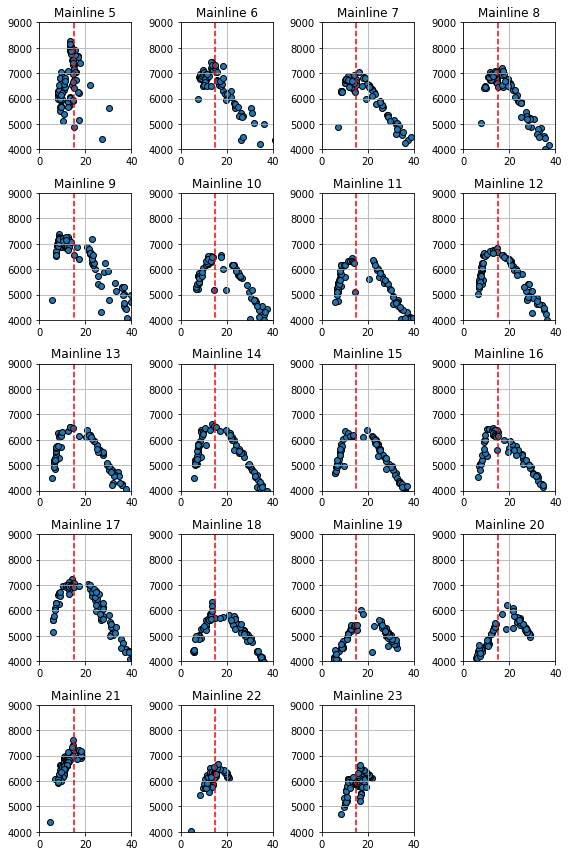

In [10]:
plt.figure(figsize=(8, 12))

for i in range(5, 24):
    plt.subplot(5, 4, i-4)
    
    plt.scatter(simMainOcc_5min[i-5, :], simMainFlow_5min[i-5, :], edgecolors="k")
    
    plt.plot([15, 15], [0, 10000], 'r--')
    
    plt.title("Mainline " + str(i))

    plt.ylim([4000, 9000])
    plt.xlim([0, 40])
    
    plt.grid()
    
    
plt.tight_layout()

plt.savefig(outputDir+"/mainlineFD.pdf")

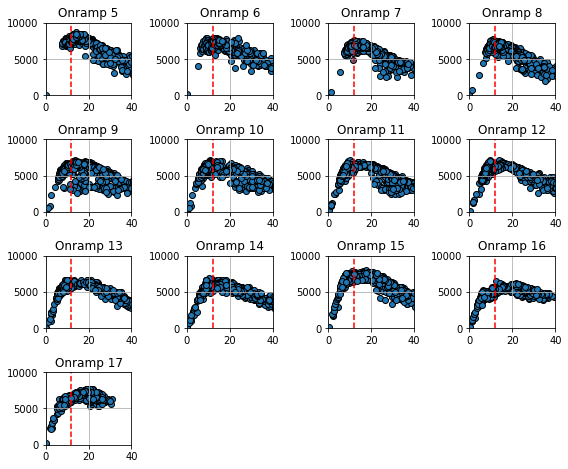

In [11]:
plt.figure(figsize=(8, 8))

for i in range(5, 18):
    plt.subplot(5, 4, i-4)
    
    plt.scatter(meteringInductionLoops[i-5].warehouse["edgeOcc"],
                meteringInductionLoops[i-5].warehouse["edgeFlow"], edgecolors='k')
    
    plt.title("Onramp " + str(i))

    plt.plot([12, 12], [0, 10000], 'r--')
    
    plt.ylim([0, 10000])
    plt.xlim([0, 40])
    
    plt.grid()
    

    #plt.legend(["True", "Sim"])
    
plt.tight_layout()

plt.savefig(outputDir+"/mergingFD(30s).pdf")

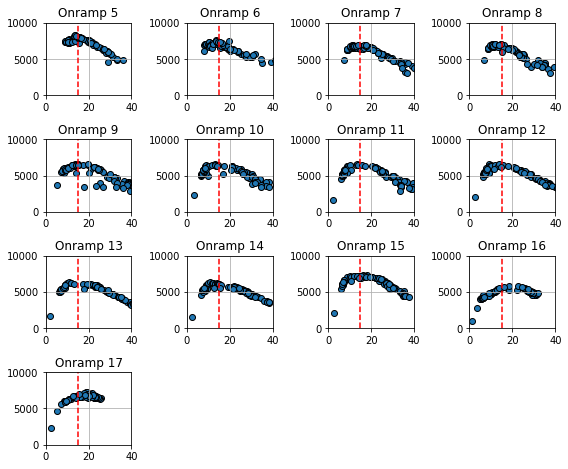

In [12]:
plt.figure(figsize=(8, 8))

for i in range(5, 18):
    plt.subplot(5, 4, i-4)
    
    plt.scatter(ytlib.downsample(np.array(meteringInductionLoops[i-5].warehouse["edgeOcc"][1:]), downsamplingSize=10, dim=0),
                ytlib.downsample(np.array(meteringInductionLoops[i-5].warehouse["edgeFlow"][1:]), downsamplingSize=10, dim=0), 
                edgecolors='k')
    
    plt.title("Onramp " + str(i))

    plt.plot([15, 15], [0, 10000], 'r--')
    
    plt.ylim([0, 10000])
    plt.xlim([0, 40])
    
    plt.grid()
        
plt.tight_layout()

plt.savefig(outputDir+"/mergingFD(5min).pdf")

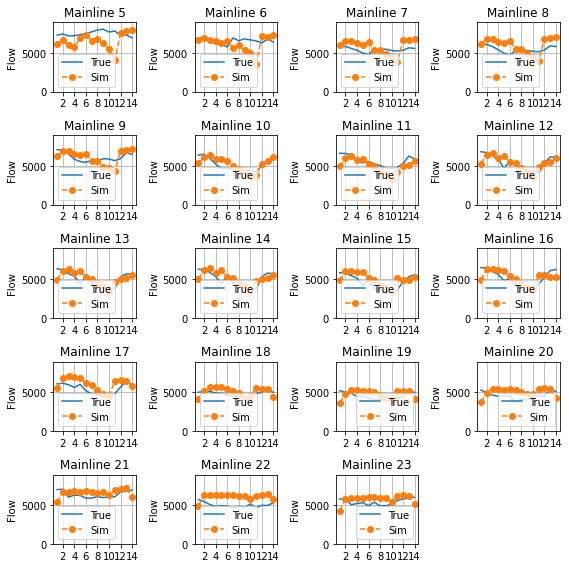

In [13]:
plt.figure(figsize=(8, 8))

for i in range(5, 24):
    plt.subplot(5, 4, i-4)
    
    plt.plot(range(1, 15), np.array(trueMainFlow_30min)[i-1, :])
    plt.plot(range(1, 15), simMainFlow_30min[i-5, :], 'o--')
    
    plt.ylim([0, 9000])
    plt.title("Mainline " + str(i))
    plt.ylabel("Flow")
    
    plt.gca().set_xticks([2, 4, 6, 8, 10, 12, 14])
    plt.grid()
    
    plt.legend(["True", "Sim"])
    
plt.tight_layout()

plt.savefig(outputDir+"/mainlineFlow.pdf")

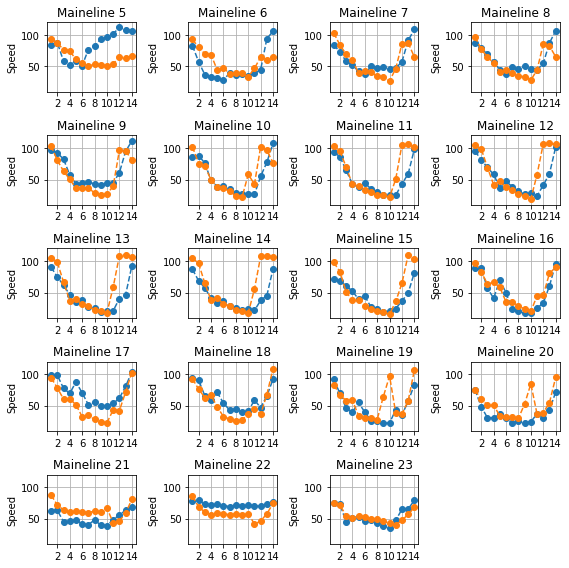

In [14]:
plt.figure(figsize=(8, 8))

for i in range(5, 24):
    plt.subplot(5, 4, i-4)
    
    plt.plot(range(1, 15), np.array(trueMainSpeed_30min)[i-1, :], 'o--')
    plt.plot(range(1, 15), simMainSpeed_30min[i-5, :], 'o--')
    
    plt.ylim([10, 120])
    plt.title("Maineline "+ str(i))
    plt.ylabel("Speed")
    
    plt.gca().set_xticks([2, 4, 6, 8, 10, 12, 14])
    plt.grid()
    
    #plt.legend(["True", "Sim"])
    
plt.tight_layout()

plt.savefig(outputDir+"/mainlineSpeed.pdf")

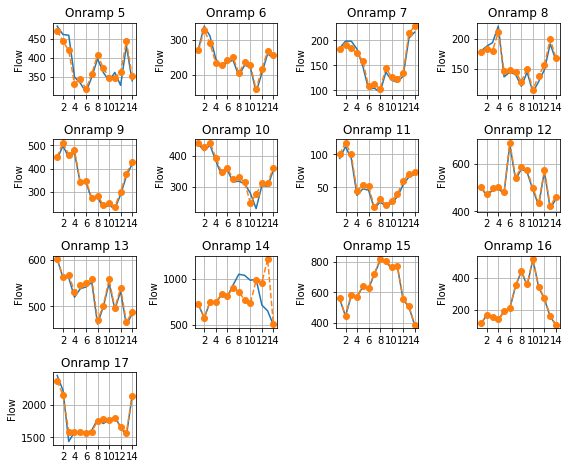

In [15]:
plt.figure(figsize=(8, 8))

for i in range(5, 18):
    plt.subplot(5, 4, i-4)
    
    plt.plot(range(1, 15), np.array(trueOnrampFlow_30min)[i-1, :])
    plt.plot(range(1, 15), simOnrampFlow_30min[i-5, :], 'o--')
    
    plt.title("Onramp " + str(i))
    
    plt.ylabel("Flow")

    plt.gca().set_xticks([2, 4, 6, 8, 10, 12, 14])
    plt.grid()
    
    #plt.legend(["True", "Sim"])
    
plt.tight_layout()

plt.savefig(outputDir+"/onrampFlow.pdf")

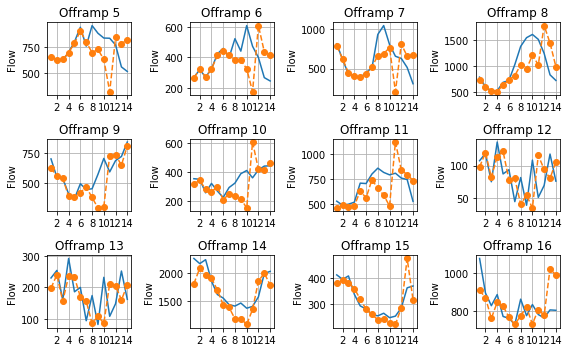

In [16]:
plt.figure(figsize=(8, 8))

for i in range(5, 17):
    plt.subplot(5, 4, i-4)
    
    plt.plot(range(1, 15), np.array(trueOfframpFlow_30min)[i-1, :])
    plt.plot(range(1, 15), simOfframpFlow_30min[i-5, :], 'o--')
    
    #plt.ylim([20, 120])
    plt.title("Offramp " + str(i))

    plt.ylabel("Flow")

    plt.gca().set_xticks([2, 4, 6, 8, 10, 12, 14])
    plt.grid()
    
    #plt.legend(["True", "Sim"])
    
plt.tight_layout()

plt.savefig(outputDir+"/offrampFlow.pdf")

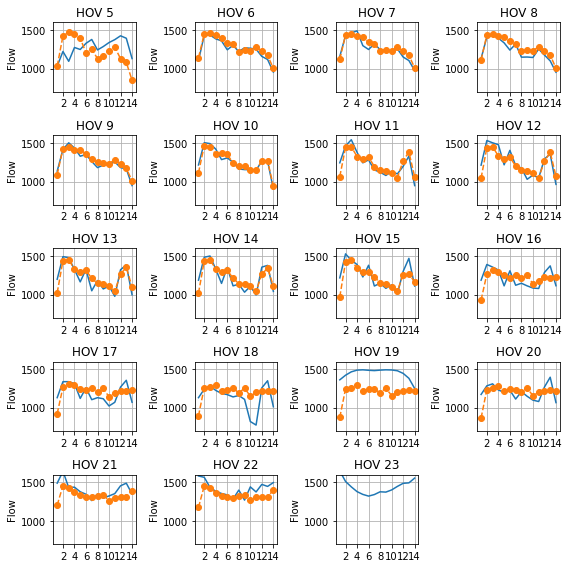

In [17]:
plt.figure(figsize=(8, 8))

for i in range(5, 24):
    plt.subplot(5, 4, i-4)
    
    plt.plot(range(1, 15), np.array(trueHOVFlow_30min)[i-1, :])
    plt.plot(range(1, 15), simHOVFlow_30min[i-5, :], 'o--')
    
    plt.ylim([700, 1600])
    plt.title("HOV "+str(i))
    
    plt.ylabel("Flow")
    
    plt.gca().set_xticks([2, 4, 6, 8, 10, 12, 14])
    plt.grid()
    
    #plt.legend(["True", "Sim"])
    
plt.tight_layout()

plt.savefig(outputDir+"/hovFlow.pdf")

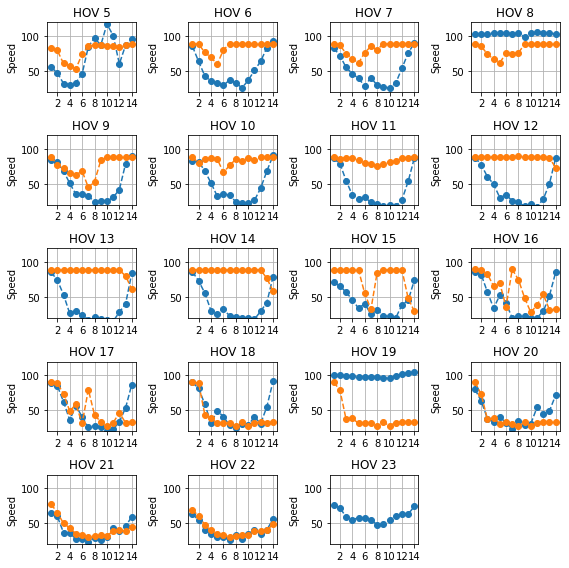

In [18]:
plt.figure(figsize=(8, 8))

for i in range(5, 24):
    plt.subplot(5, 4, i-4)
    
    plt.plot(range(1, 15), np.array(trueHOVSpeed_30min)[i-1, :], 'o--')
    plt.plot(range(1, 15), simHOVSpeed_30min[i-5, :], 'o--')

    plt.ylim([20, 120])
    plt.title("HOV " + str(i))
    
    plt.ylabel("Speed")

    plt.gca().set_xticks([2, 4, 6, 8, 10, 12, 14])
    plt.grid()
    
    #plt.legend(["True", "Sim"])
    
plt.tight_layout()

plt.savefig(outputDir+"/hovSpeed.pdf")

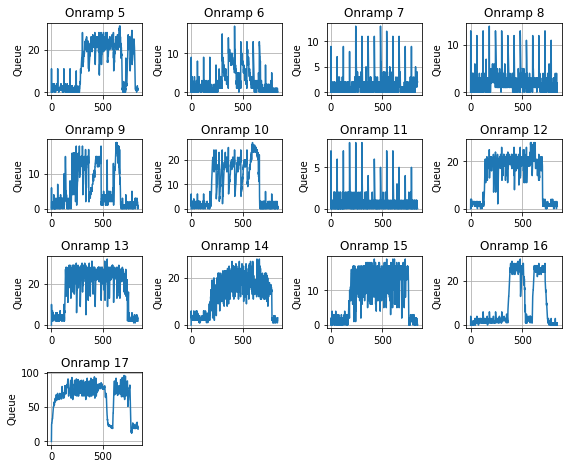

In [19]:
plt.figure(figsize=(8, 8))

for i in range(5, 18):
    plt.subplot(5, 4, i-4)
    
    plt.plot(rampLaneAreaDetectors[i-5].warehouse["numVeh"])
    
    plt.title("Onramp " + str(i))
    
    plt.ylabel("Queue")

    #plt.plot([15, 15], [0, 10000], 'r--')
    
    #plt.ylim([0, 10000])
    #plt.xlim([0, 40])
    
    plt.grid()
        
plt.tight_layout()

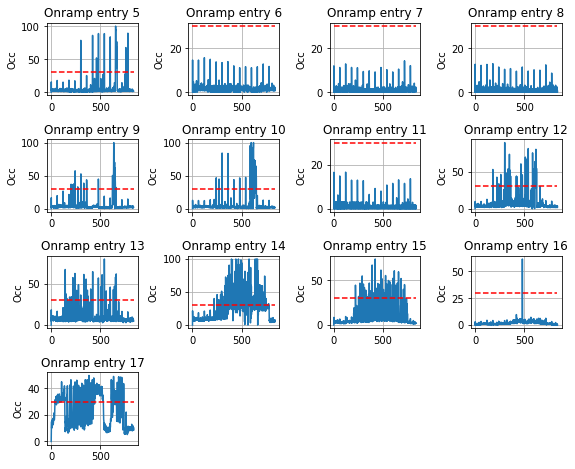

In [20]:
plt.figure(figsize=(8, 8))

for i in range(5, 18):
    plt.subplot(5, 4, i-4)
    
    plt.plot(rampEntryInductionLoops[i-5].warehouse["edgeOcc"])
    
    plt.ylabel("Occ")
    
    plt.title("Onramp entry " + str(i))

    plt.plot([0, 840], [30]*2, 'r--')

    #plt.ylim([0, 10000])
    #plt.xlim([0, 40])
    
    plt.grid()
        
plt.tight_layout()

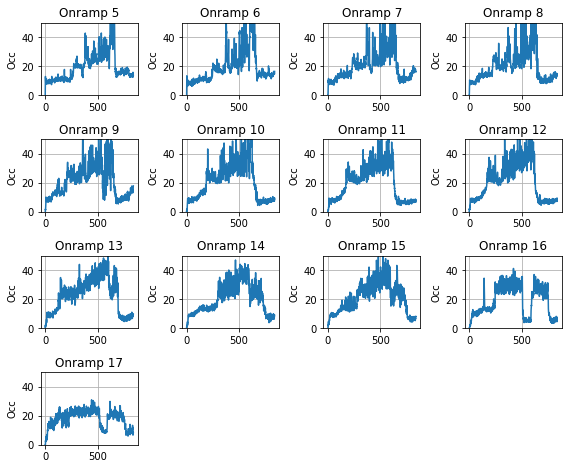

In [21]:
plt.figure(figsize=(8, 8))

for i in range(5, 18):
    plt.subplot(5, 4, i-4)
    
    plt.plot(meteringInductionLoops[i-5].warehouse["edgeOcc"])
    
    plt.title("Onramp " + str(i))

    plt.ylabel("Occ")
        
    #plt.plot([15, 15], [0, 10000], 'r--')
    
    plt.ylim([0, 50])
    #plt.xlim([0, 40])
    
    plt.grid()
        
plt.tight_layout()